In [1]:
%matplotlib inline
#- standard imports
import numpy as np
import os

#- graspy datasets and utils
from graspy.utils import symmetrize
from graspy.plot import heatmap

from mgcpy.independence_tests.mgc.mgc import MGC

#- rpy2
from rpy2 import robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from utils import sort_graph, _sort_inds, binarize, identity, to_distance_mtx
import pickle
import networkx as nx

In [2]:
C_left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
C_right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)
C_left = symmetrize(C_left)
C_right = symmetrize(C_right)

In [3]:
#- Process labels
left_labels = np.loadtxt('../data/drosophila/left_cell_labels.csv', dtype=str)
n_L = len(left_labels)
right_labels = np.loadtxt('../data/drosophila/right_cell_labels.csv', dtype=str)
n_R = len(right_labels)
unique_L, counts_L = np.unique(left_labels, return_counts = True)
unique_R, counts_R = np.unique(right_labels, return_counts = True)

#- Permute adjacencies so that seeds are in first n_seeds
P_left = np.eye(len(left_labels))
seeds_left = counts_L[0]
for i in range(counts_L[2]):
    e_nonseed = np.zeros(n_L)
    e_nonseed[seeds_left] = 1
    
    e_seed = np.zeros(n_L)
    e_seed[np.sum(counts_L[:2]) + i] = 1
    
    P_left[seeds_left, :] = e_seed
    P_left[np.sum(counts_L[:2]) + i, :] = e_nonseed
    seeds_left += 1

In [5]:
np.where(P_left==1)[1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [6]:
unique_L

array(['I', 'K', 'O', 'P'], dtype='<U1')

In [7]:
counts_L

array([ 21, 101,  29,  58])

In [8]:
unique_R

array(['I', 'K', 'O', 'P'], dtype='<U1')

In [9]:
counts_R

array([ 21, 100,  29,  63])

In [10]:
C_left_seeds = P_left @ C_left @ P_left.T

In [11]:
np.where(left_labels==['I'])

(array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121]),)

In [4]:
left_seeds = np.zeros(left_labels.size, dtype=int)
left_seeds[:counts_L[0]] = np.where(left_labels=='I')[0]
left_seeds[counts_L[0]:counts_L[0]+counts_L[2]] = np.where(left_labels=='O')[0]
left_seeds[counts_L[0]+counts_L[2]:counts_L[0]+counts_L[2]+counts_L[1]] = np.where(left_labels=='K')[0]
left_seeds[counts_L[0]+counts_L[2]+counts_L[1]:] = np.where(left_labels=='P')[0]

In [5]:
left_seeds

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [6]:
right_seeds = np.zeros(right_labels.size, dtype=int)
right_seeds[:counts_R[0]] = np.where(right_labels=='I')[0]
right_seeds[counts_R[0]:counts_R[0]+counts_R[2]] = np.where(right_labels=='O')[0]
right_seeds[counts_R[0]+counts_R[2]:counts_R[0]+counts_R[2]+counts_R[1]] = np.where(right_labels=='K')[0]
right_seeds[counts_R[0]+counts_R[2]+counts_R[1]:] = np.where(right_labels=='P')[0]

In [7]:
right_seeds

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

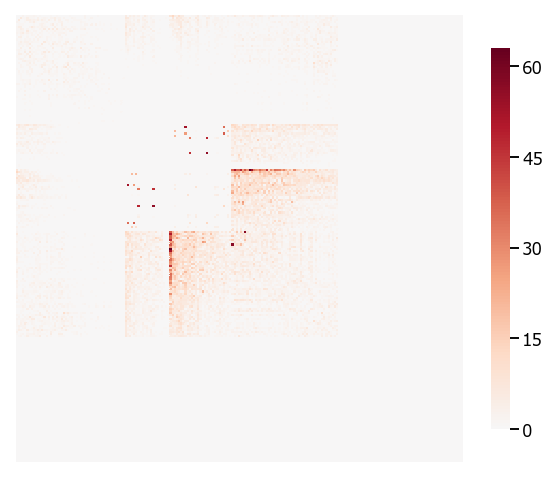

In [8]:
heatmap(sort_graph(C_left, left_seeds))

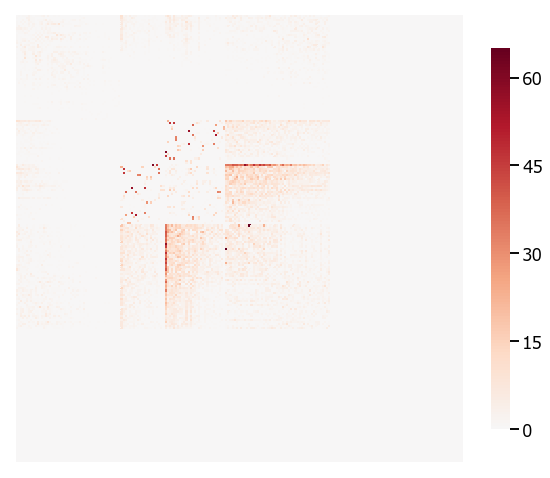

In [9]:
heatmap(sort_graph(C_right, right_seeds))

In [10]:
with open('../data/drosophila/seeds_weighted_P.pkl', 'rb') as f:
    w_graph_match = pickle.load(f)
w_graph_match = np.reshape(w_graph_match, (213, 213))

with open('../data/drosophila/weighted_left_permuted.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/weighted_right_permuted.pkl', 'rb') as f:
    right = pickle.load(f)

In [11]:
left_labels_sorted = left_labels[left_seeds]
right_labels_sorted = right_labels[right_seeds]
right_labels_sorted

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [12]:
right_labels_sorted[np.where(w_graph_match==1)[1]]

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'P', 'P', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'P', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'P', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [13]:
left_labels_sorted

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [34]:
np.where(w_graph_match==1)[1][np.where(np.where(w_graph_match==1)[1][:150] >= 150)]

array([210, 211, 209, 150])

In [39]:
np.nonzero(right[[210, 211, 209, 150], :])

(array([], dtype=int64), array([], dtype=int64))

In [16]:
np.where(w_graph_match==1)[1][209:]

array([ 71,  70,  69, 212])

In [18]:
np.nonzero(right[71, :])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  65,  67,  74,
         76,  77, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),)

In [19]:
np.nonzero(right[70, :])

(array([  3,  81,  83, 127, 144]),)

In [20]:
np.nonzero(right[69, :])

(array([  4,   5,   9,  12,  22,  81,  83, 100, 108, 117, 127, 131, 132,
        137, 140, 148, 149]),)

In [21]:
np.nonzero(right[212, :])

(array([], dtype=int64),)

### Original mistakes

In [124]:
right_nx = nx.from_numpy_matrix(right)
right_nx.remove_nodes_from(np.where(w_graph_match==1)[1][left.shape[0]:])
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

# right (removed nodes and sorted)
right_sorted = sort_graph(right_rm, np.where(w_graph_match==1)[1][:left.shape[0]])

nonsense!

In [126]:
inner_labels = np.where(w_graph_match==1)[1][:left.shape[0]]
_sort_inds(inner_labels, np.ones_like(inner_labels))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 150,  50,
        51,  53,  59,  68,  58,  94, 149,  63,  56,  54,  60,  87,  82,
        98,  62,  66,  64,  71,  72,  76,  74,  79,  81,  80,  73,  84,
        61,  78,  77,  52,  83,  85,  88,  93,  55,  91,  89,  86,  57,
        95,  67,  92,  75,  90,  97,  96, 100, 103, 105, 107, 118, 106,
       111, 110, 109, 113, 101, 104, 126, 121, 102, 115, 117, 112, 122,
       108, 116, 120, 114, 119, 127, 131, 129, 123, 125,  65, 132, 135,
       124, 134, 130, 133, 138, 128, 139, 137, 140, 136, 147, 141, 148,
       144, 142, 145, 146, 143, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

### The correct thing to do

In [19]:
right_sorted = sort_graph(right, np.where(w_graph_match==1)[1])
right_nx = nx.from_numpy_matrix(right_sorted)
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

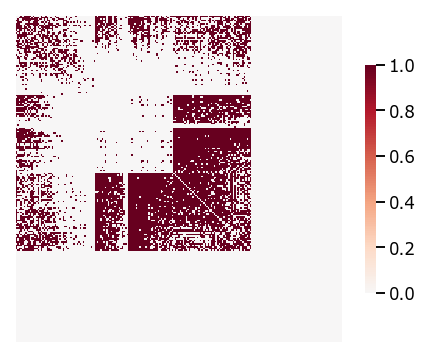

In [20]:
heatmap(binarize(left), figsize=(8, 6))

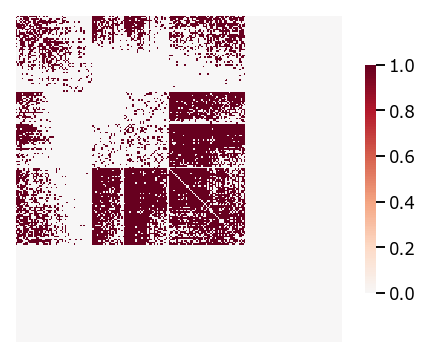

In [21]:
heatmap(binarize(right), figsize=(8, 6))

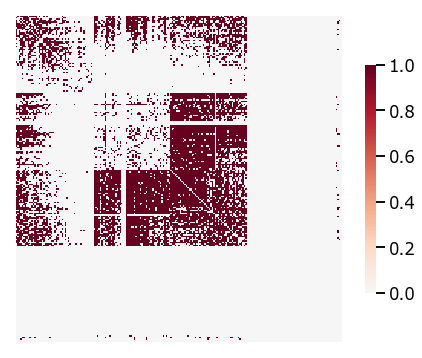

In [22]:
heatmap(binarize(right_sorted), figsize=(8, 6))

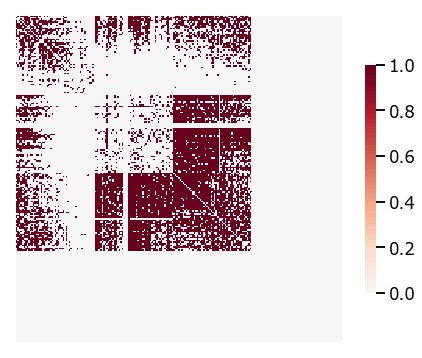

In [23]:
heatmap(binarize(right_rm), figsize=(8, 6))

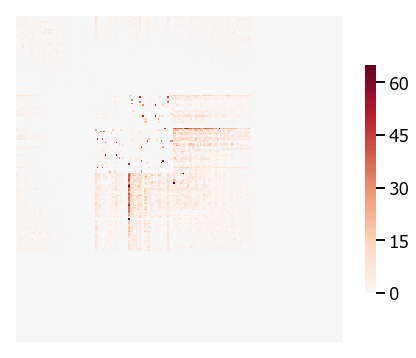

In [24]:
heatmap(right_rm, figsize=(8, 6))

In [135]:
mgc = MGC(compute_distance_matrix=identity)
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))

(0.739048660539342,
 {'local_correlation_matrix': array([[-4.58074855e-05,  1.98756067e-01,  2.72451649e-01, ...,
           1.47239067e-01,  1.47237612e-01,  1.47046337e-01],
         [ 4.16275950e-01,  7.46653985e-01,  7.06780401e-01, ...,
           6.82852922e-01,  6.82853227e-01,  6.82357383e-01],
         [ 3.10668150e-01,  7.47327477e-01,  7.47481350e-01, ...,
           7.04465240e-01,  7.04469086e-01,  7.04163781e-01],
         ...,
         [ 1.63360690e-01,  6.88799589e-01,  6.63986263e-01, ...,
           7.29261966e-01,  7.29304828e-01,  7.29861111e-01],
         [ 1.63362242e-01,  6.88150801e-01,  6.63537817e-01, ...,
           7.29011755e-01,  7.29054606e-01,  7.29610457e-01],
         [ 1.63128978e-01,  6.84774913e-01,  6.61174880e-01, ...,
           7.27934126e-01,  7.27975433e-01,  7.28448708e-01]]),
  'optimal_scale': [30, 14]})

### The bug in SBM script

In [101]:
with open('../data/drosophila/seeds_weighted_P_1.pkl', 'rb') as f:
    w_graph_match = pickle.load(f)
w_graph_match = np.reshape(w_graph_match, (213, 213))

with open('../data/drosophila/weighted_left_permuted_1.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/weighted_right_permuted_1.pkl', 'rb') as f:
    right = pickle.load(f)

In [102]:
right_sorted = sort_graph(right, np.where(w_graph_match==1)[1])

In [103]:
right_nx = nx.from_numpy_matrix(right_sorted)
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

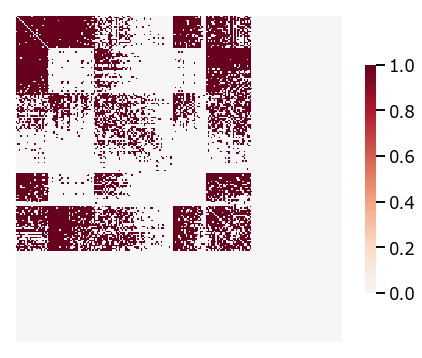

In [104]:
heatmap(binarize(left), figsize=(8, 6))

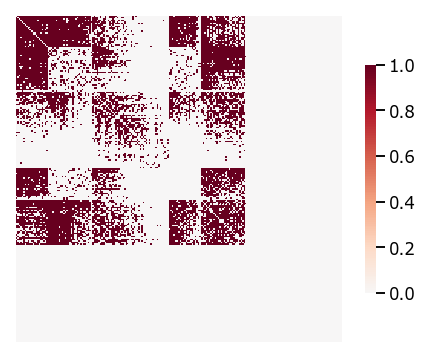

In [105]:
heatmap(binarize(right), figsize=(8, 6))

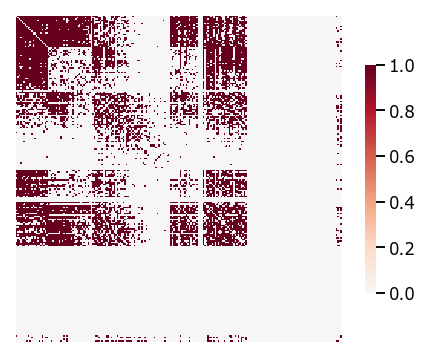

In [106]:
heatmap(binarize(right_sorted), figsize=(8, 6))

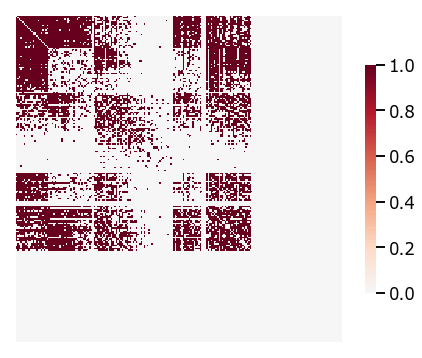

In [107]:
heatmap(binarize(right_rm), figsize=(8, 6))

In [112]:
mgc = MGC(compute_distance_matrix=identity)
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))

(0.5978750328014679,
 {'local_correlation_matrix': array([[-4.58074855e-05,  1.13680214e-01,  7.92178387e-02, ...,
           8.22408105e-02,  8.22405341e-02,  8.21637357e-02],
         [-4.90263377e-04,  2.16592502e-01,  2.74002315e-01, ...,
           4.66271850e-01,  4.66276121e-01,  4.64933075e-01],
         [-6.44921048e-04,  2.04923064e-01,  2.47489013e-01, ...,
           4.51068948e-01,  4.51077400e-01,  4.50299597e-01],
         ...,
         [-1.11049468e-03,  4.14337747e-01,  4.09743419e-01, ...,
           5.87024331e-01,  5.87102175e-01,  5.87369945e-01],
         [-1.10987839e-03,  4.14347138e-01,  4.09754004e-01, ...,
           5.87001429e-01,  5.87079259e-01,  5.87346201e-01],
         [-1.05023837e-03,  4.14260703e-01,  4.09793747e-01, ...,
           5.86977193e-01,  5.87053407e-01,  5.87237111e-01]]),
  'optimal_scale': [25, 14]})

### Check unweighted match

In [29]:
with open('../data/drosophila/seeds_unweighted_P.pkl', 'rb') as f:
    graph_match = pickle.load(f)
graph_match = np.reshape(graph_match, (213, 213))

with open('../data/drosophila/unweighted_left_permuted.pkl', 'rb') as f:
    left = pickle.load(f)
with open('../data/drosophila/unweighted_right_permuted.pkl', 'rb') as f:
    right = pickle.load(f)

In [30]:
right_sorted = sort_graph(right, np.where(graph_match==1)[1])
right_nx = nx.from_numpy_matrix(right_sorted)
right_nx.remove_nodes_from(np.arange(left.shape[0], right.shape[0]))
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

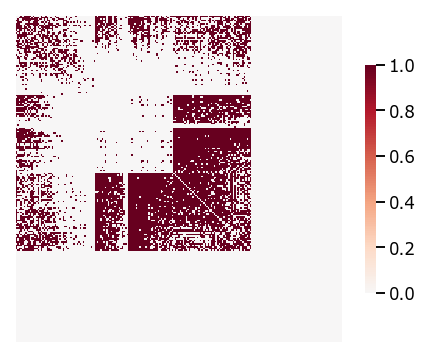

In [31]:
heatmap(left, figsize=(8, 6))

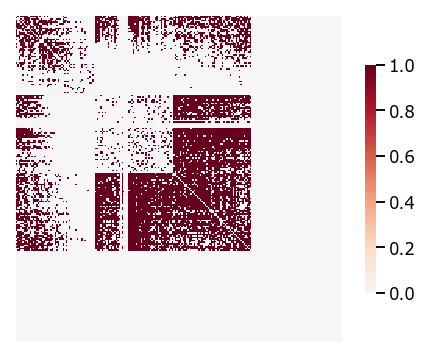

In [32]:
heatmap(right_rm, figsize=(8, 6))

In [33]:
mgc = MGC(compute_distance_matrix=identity)
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_rm))

(0.6695986873583826,
 {'local_correlation_matrix': array([[0.66959869, 0.6354944 ],
         [0.63468054, 0.53171925]]), 'optimal_scale': [1, 1]})